# Running RAMP OpenCL model with dynamic calibration

### Parameter definitions
The OpenCL RAMP model creates a synthetic population and simulates the movements of individuals between various locations (home, work, school, shops). If an individual is infected then they impart an infection risk on to the locations that they visit. The severity of this infection risk is determined by whether the individual is presymptomatic, asymptomatic or symptomatic (the **individual's hazard rating**). The locations in the model thus come to have an infection risk, based upon how many infected individuals from each infection status have visited. When susceptible individuals without the disease visit these locations their risk of being infected is determined by the location's infection risk, alongside the transmission hazard associated with that kind of location (the location's hazard rating). An additional hazard rating, the current risk beta, is used to control the general transmissability of the disease (?) 

### Parameter calibration
The current risk beta parameter is calibrated in [this notebook](http://localhost:8888/notebooks/Users/gy17m2a/OneDrive%20-%20University%20of%20Leeds/Project/RAMP-UA/experiments/calibration/abc-2-NewObs.ipynb). This involves determining a prior distribution for both the current risk beta parameter, and for the individual and location hazard parameters. Approximate Bayesian Computation (ABC) is then used to approximate the likelihood of different parameter values by running the model a large number of times. Each time parameter values are drawn randomly from the prior distributions, and the parameter values from the simulations with results closest to the observations are kept. A fitness function is used to assess the similarity of model results to observations. In this case, the Euclidean difference between the observed number of cases per week and the simulated number of cases per week is calculated. In this script, the model is ran using ABC for 105 days, with two populations. 

In this notebook, the current risk beta parameter value which was associated with the highest fitness in the final population in the calibration process above is set as a constant, and assumed not to change over the life of the disease. However, as the disease evolves, it is expected that the other parameters pertaining to the hazard associated with individuals and locations will change. If a model is calibrated just once using historical data then it will be unable to account for this parameter evolution. However, if it is dynamically calibrated, then it can be optimised in response to changes in parameter values in real time. Dynamic calibration involves re-calibrating the model at each time-step (e.g. after one day, one week etc), and using the best performing parameter value from the previous time-step for the next time-step. 

### Parameter priors
ABC requires prior distributions to be specified for the parameters.

<ins>Location hazards</ins> 
 - `Home` (transmission hazard associated with being with an infected individual at home)
     - <i>Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0. </i>
 - `Retail` (transmission hazard associated with being with an infected individual in a shop)
     - <i> Uniform between 0 and 1 </i>
 - `PrimarySchool` (transmission hazard associated with being with an infected individual at primary school)
     - <i> Uniform between 0 and 1 </i> 
 - `SecondarySchool` (transmission hazard associated with being with an infected individual at secondary school)
     - <i> Uniform between 0 and 1 </i> 
 - `Work` (transmission hazard associated with being with an infected individual at work)
     - <i> Uniform between 0 and 1 </i> 
 
<ins> Individual hazards</ins> 
 - `asymptomatic` (transmission hazard associated with asymptomatic individuals)  
      - <i> This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). </i>
 - `presymptomatic` (transmission hazard associated with presymptomatic individuals)  
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ? </i>
 - `symptomatic` (transmission hazard associated with symptomatic individuals)   
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ?)</i>       

### Import modules

In [1]:
#### Import modules required
import multiprocessing as mp
import numpy as np
import os
import itertools
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
import datetime
from matplotlib import cm

os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/Project/RAMP-UA/experiments/calibration")

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging

logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Import arbitrary distribution class for using posterior estimates as new priors
sys.path.append('..')
from arbitrary_distribution import ArbitraryDistribution, GreaterThanZeroParameterTransition

# RAMP model
from microsim.initialisation_cache import InitialisationCache

# Bespoke RAMP classes for running the model
import sys

sys.path.append('..')
from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

# Set this to False to recalculate all results (good on HPC or whatever).
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


#### Setup Model

 Read in parameters

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "


Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).

In [3]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

#### Create observed cases data

In [4]:
# Observed cases data
cases_msoa_weekly = pd.read_csv("observation_data/weekly_cases_msoas_shifted_mpld_smoothed_IS.csv")
# remove date column
cases_msoa_weekly = cases_msoa_weekly.iloc[:, 1:]
# Transpose
cases_msoa_weekly = cases_msoa_weekly.T

# Observations are cases per msoa.
# Store as an array for us in model (more efficient?)
# (first axis is the msoa number, second is the day)
observations_weekly_array = cases_msoa_weekly.to_numpy()

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()

# Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()

# Read in daily msoa case data (interpoalted from weekly)
cases_msoa_daily = pd.read_csv("observation_data/daily_cases_msoas_shifted_mpld_smoothed_IS.csv")
#Create new dataframe with cumulative sums rather than cases per day
#cases_msoa_daily['CumulativeCases'] = cases_msoa_daily['OriginalCases'].cumsum()
# remove date column
cases_msoa_daily = cases_msoa_daily.iloc[:, 1:]
cases_msoa_daily = cases_msoa_daily.T
cases_msoa_daily.columns = range(1,(cases_msoa_daily.shape[1])+1)
cases_msoa_daily = cases_msoa_daily.add_prefix('Day')

cases_devon_weekly.head()

,Date,OriginalCases,CumulativeCases
0,2020-03-22,715.856727,715.856727
1,2020-03-29,1419.759454,2135.616181
2,2020-04-05,2077.646413,4213.262594
3,2020-04-12,2499.510276,6712.772869
4,2020-04-19,2442.761446,9155.534315


## Run model with default parameter values 

This shows what happens with the 'default' (manually calibrated) model, i.e. using the parameter values specified in the parameters file

#### Initialise model

In [94]:
## Define parameters
ITERATIONS = 28  # Number of iterations to run for
assert (ITERATIONS /7).is_integer() # check it is divisible by 7 
NUM_SEED_DAYS = 7  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# Think x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
OpenCLRunner.init( iterations = ITERATIONS, repetitions = REPETITIONS, observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE, opencl_dir = OPENCL_DIR,snapshot_filepath = SNAPSHOT_FILEPATH,
    num_seed_days = NUM_SEED_DAYS)

#### Run model

In [95]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness_manualcalibration, sim_manualcalibration, obs_manualcalibration, out_params_manualcalibration, summaries_manualcalibration) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True, quiet = False)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.76s/it]


#### Plot results

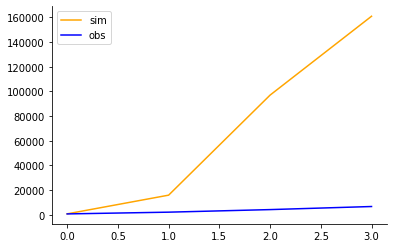

In [96]:
# Check the model returns the observations correctly i.e. that theyre the same length
np.array_equal(obs_manualcalibration, cases_devon_daily.loc[:len(sim_manualcalibration)-1,"CumulativeCases"])

# Plot
fig, ax = plt.subplots(1,1)
x = range(len(sim_manualcalibration))
ax.plot(x, sim_manualcalibration, label="sim", color="orange")
ax.plot(x, obs_manualcalibration, label="obs", color="blue")
ax.legend()


## Run model with dynamic calibration
### Define parameter values
#### Define constants
These are not touched by ABC. Include parameters that should not be optimised.

In [12]:
const_params_dict = {"home": 1.0}

#### Define random variables and the prior distributions
Random variables are the global parameters.

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


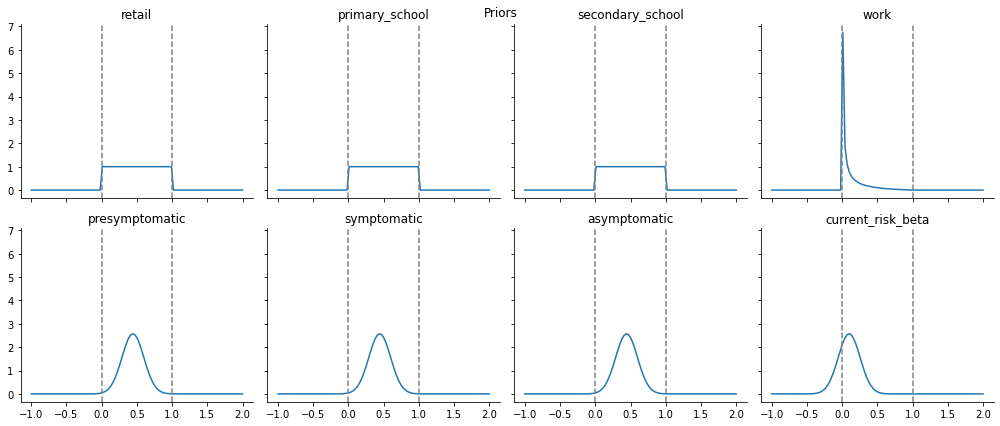

In [9]:
# Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_)
# The following should all be constant (overiding whatever is in the default.yml parameters file)
# OpenCLRunner.set_constants( {"home": 1.0 })

# FYI this is how to represent with discrete discributions and one possible value (hack that didn't work):
# home_rv, current_risk_beta_rv = ( pyabc.RV('rv_discrete', values=([0.03], [1.0])) for _ in range(2) )
current_risk_beta_rv = pyabc.RV("norm", 0.1, 0.155)

# Now the random variables:
# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook).
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = { "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv, 
    "current_risk_beta":current_risk_beta_rv}

# Plot prior distributions
fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")
fig.tight_layout()
fig.suptitle("Priors")
fig.show()

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

#### Define parameters for running model

In [21]:
# Set the size of a data assimilation window in days:
da_window_size =28

# Initialise the population
DATA_DIR = os.path.join("..", "..", "devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                    "few cells up that initialises the population")

individuals_df, activity_locations = cache.read_from_cache()
print(f"Activity locations: {activity_locations}")


# Dictionary with parameters for running model
admin_params = {"quiet": True, "use_gpu": True, "store_detailed_counts": True, "start_day": 0,  "run_length": da_window_size,
                "current_particle_pop_df": None,  "parameters_file": PARAMETERS_FILE, "snapshot_file": SNAPSHOT_FILEPATH, 
                "opencl_dir": OPENCL_DIR, "individuals_df": individuals_df, 
                "observations_weekly_array": observations_weekly_array,'num_seed_days' :7}

Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


#### Define dynamic calibration loop

In [77]:
# Create dictionaries to store the dfs, weights or history from each window (don't need all of these, but testing for now)
dfs_dict, weights_dict, history_dict = {}, {},{}

# Store starting time to use to calculate how long processing the whole window has taken
starting_windows_time = datetime.datetime.now()

# Create template for model
template = OpenCLWrapper(const_params_dict, **admin_params)
# Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
template.__name__ = OpenCLWrapper.__name__

# Set up model
abc = pyabc.ABCSMC(
    models=template,  # Model (could be a list)
    parameter_priors=original_priors,  # Priors (could be a list)
    distance_function=OpenCLWrapper.dummy_distance,  # Distance function
    sampler=pyabc.sampler.SingleCoreSampler(),
    transitions=GreaterThanZeroParameterTransition())

# Prepare to run the model
db_path = ("sqlite:///" + "test2.db")  # Path to database

# abc.new() needs the database location and any observations that we will use (these are passed to the
# distance_function provided to pyabc.ABCSMC above). Currently the observations are provided to the model
# when it is initialised and these are then used at the end of the model run() function. So they don't
# need to be provided here.
abc_history = abc.new(db=db_path,observed_sum_stat=None)  # {'observation': observations_array, "individuals": individuals_df}
run_id = abc_history.id

# Run model
abc_history = abc.run(max_nr_populations=2)

# Save some info on the posterior parameter distributions.
for t in range(0, abc.history.max_t + 1):

    # for this t (population) extract the 100 particle parameter values, and their weights
    df_t1, w_t1 = abc.history.get_distribution(m=0, t=t)

    # Save these for use in plotting the prior on the plot of parameter values in each population
    dfs_dict["pop{}".format(t)] = df_t1
    weights_dict["pop{}".format(t)] = w_t1
#   history_dict["w{}".format(window_number)] = abc_history


In [66]:
# Create template for model
template = OpenCLWrapper(const_params_dict, **admin_params)
# Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
template.__name__ = OpenCLWrapper.__name__

# Set up model
abc_continued = pyabc.ABCSMC(
    models=template,  # Model (could be a list)
    parameter_priors=original_priors,  # Priors (could be a list)
    distance_function=OpenCLWrapper.dummy_distance,  # Distance function
    sampler=pyabc.sampler.SingleCoreSampler(),
    transitions=GreaterThanZeroParameterTransition())

# To resume a run, use the load method to load the necessary data. We pass to this method the id of the run we want to continue
abc_continued.load(db_path, run_id)
# run it
abc_continued.run(max_nr_populations=1)

ABC INFO: t: 2, eps: 1.36197239e+05.
..\arbitrary_distribution.py:117: UserWarning: NoZeroPatameterTransition has tried 10 times to draw a sample for which all parameters are greater than 0
  warnings.warn(f"NoZeroPatameterTransition has tried {counter} times to draw a sample for "
..\arbitrary_distribution.py:117: UserWarning: NoZeroPatameterTransition has tried 20 times to draw a sample for which all parameters are greater than 0
  warnings.warn(f"NoZeroPatameterTransition has tried {counter} times to draw a sample for "
ABC INFO: Accepted: 100 / 213 = 4.6948e-01, ESS: 6.4658e+00.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=4, duration=6:09:59.070662, end_time=2022-03-11 17:26:17>


In [72]:
abc_history.n_populations

3

#### Analyse the posterior
Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

Note about the distrubtion returned by get_distribution: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [38]:
_df, _w = abc_history.get_distribution(m=0, t=abc_history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,presymptomatic,primary_school,retail,secondary_school,symptomatic,work,weight
0,122,0.755024,0.002071,0.689147,0.781102,0.400937,0.632461,0.361537,0.063283,0.200193
1,118,0.214457,0.072520,0.403672,0.709022,0.643994,0.343730,0.565362,0.000503,0.120550
2,161,0.542289,0.032939,0.403920,0.082841,0.543261,0.044621,0.658775,0.001981,0.111802
3,164,0.673494,0.014272,0.551286,0.454184,0.904746,0.527893,0.444484,0.003606,0.064075
4,126,0.458931,0.033671,0.420072,0.542309,0.822156,0.381253,0.331422,0.002209,0.046130
...,...,...,...,...,...,...,...,...,...,...
95,132,0.332370,0.055222,0.798069,0.678313,0.027083,0.479621,0.636795,0.050933,0.000172
96,133,0.196030,0.073855,0.118683,0.706194,0.149384,0.463848,0.543320,0.049542,0.000139
97,163,0.106520,0.102808,0.123163,0.574763,0.501242,0.688857,0.692332,0.050799,0.000046
98,182,0.471077,0.009629,0.053529,0.711662,0.060884,0.849763,0.276581,0.579210,0.000011


#### Plot the marginal posteriors  
The estimates of the optimal values for each parameter individually

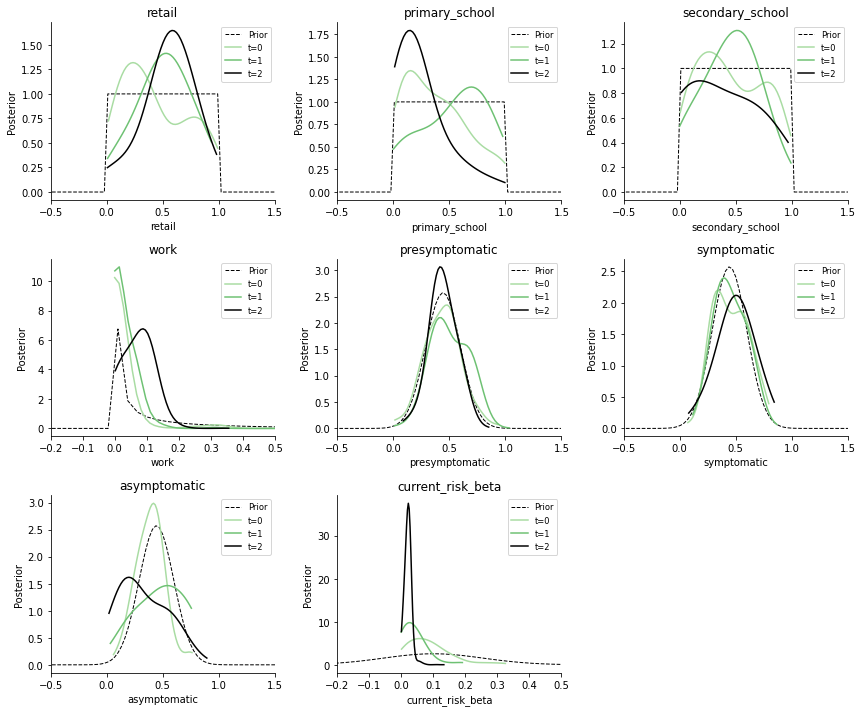

In [69]:
fig, axes = plt.subplots(3,3, figsize=(12,10))
# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, 5)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    # Add distributions
    for t in range(abc_history.max_t + 1):
        color = colors[t]
        df, w = abc_history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"t={t}", 
            #alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= 'black' if t==abc_history.max_t else color) # Make the last one black
        if param!="work":
            ax.set_xlim(-0.5,1.5)
        if param =='work':
             ax.set_xlim(-0.2,0.5)          
        if param =='current_risk_beta':
             ax.set_xlim(-0.2,0.5)                   
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
axes[2,2].set_axis_off()        
fig.tight_layout()

In [70]:
# Create dictionary to store results for each window
abc_sum_stats = {}

for t in range(0,abc_history.max_t+1):
    # Create lists to store values for each particle
    data_daily_l = []
    distances_l = []

    # Get the summary stats for the final population for this window ([1] means keep just the 
    # dataframe and not the array of weights)
    weighted_sum_stats = abc_history.get_weighted_sum_stats_for_model(t=t)[1]
    # Loop through each particle and save their distance and predictions into the lists
    for particle_no in range(0,100):
        # Get data for just this particle
        particle_x_dict = weighted_sum_stats[particle_no]
        # Get daily predictions
        data_daily = particle_x_dict["cumulative_model_diseased_by_area_gcni"]     
        # Add daily msoa predictions for this particle to list
        data_daily_l.append(data_daily)
        
        # Add distances to list
        distances_l.append(particle_x_dict['distance'])
        
    abc_sum_stats["t{}_distances".format(t)] = distances_l
    abc_sum_stats["t{}_dailydata".format(t)] = data_daily_l


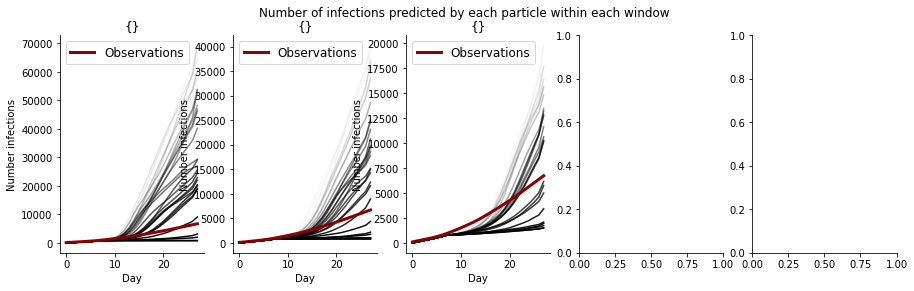

In [71]:
# Read in initial cases data (ued in seeding)
initial_cases = pd.read_csv("../../microsim/opencl/data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
initial_cases['CumulativeCases'] = initial_cases['num_cases'].cumsum()
initial_cases_weekly = pd.DataFrame({'OriginalCases':
                                    initial_cases['num_cases'].groupby(initial_cases['num_cases'].index // 7).sum()})
initial_cases_weekly['CumulativeCases'] = initial_cases_weekly.cumsum()

# Create figure
fig, axes = plt.subplots(1, 5, figsize=(15,4))
axes_number = 0
for t in range(0,abc_history.max_t+1):
        
    data_daily_l = abc_sum_stats["t{}_dailydata".format(t)]
    distance_l = abc_sum_stats["t{}_distances".format(t)]
    
    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
        
    x = range(0,len(data_daily_l[i])) 
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(data_daily_l[i])):
        axes[axes_number].plot(x, data_daily_l[i],color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)

    # Add observations
    axes[axes_number].plot(x, initial_cases['CumulativeCases'][0:len(data_daily_l[0])], label="Observations",
                           linewidth = 3, color="darkred")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    axes[axes_number].set_title("{}")

    # Apply legend
    axes[axes_number].legend(fontsize="large")

    # Set full plot title
    fig.suptitle('Number of infections predicted by each particle within each window')
    
    axes_number =axes_number +1

### Find the optimal model
Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:
 1. Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.
 2. Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).


#### 1. Sample from posterior using ABC 
Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.
 - For each of the 100 particles in the final population of the model, get the associated weight and value for each parameter
 - Estimate the underlying distribution from which these particles were drawn using KDE
 - Sample X times from this distribution

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [78]:
# ### Run default (manually calibrated) model
# This shows what happens with the 'default' (manually calibrated) model
ITERATIONS = 28  # Number of iterations to run for (must be multiple of 7)
NUM_SEED_DAYS =7   # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# Think x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(iterations = ITERATIONS, repetitions = REPETITIONS, observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE, opencl_dir = OPENCL_DIR, snapshot_filepath = SNAPSHOT_FILEPATH, 
    num_seed_days = NUM_SEED_DAYS)

In [81]:
# Define number of samples
N_samples = 100
# Retrieve information on parameter posteriors
# This returns a dataframe containing the values associated with each parameter for each of the 100 particles
# in the last availalbe population of model m. Also an array of weights associated with each particle.
df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Fit a KDE to the posterior to allow new parameters to be proposed based on the current population
# Use KDE to estimate the underlying probability distribution that generated the datasets df, w
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
# Take X samples from this new distribution
samples = kde.rvs(N_samples)

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
#         print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    param_values = {param: sample[str(param)] for param in original_priors}

    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
#     print(f"Fitness: {_fitness}.")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")
    
# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])
    
# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")
pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Finished sampling. Ignored 122 negative samples.


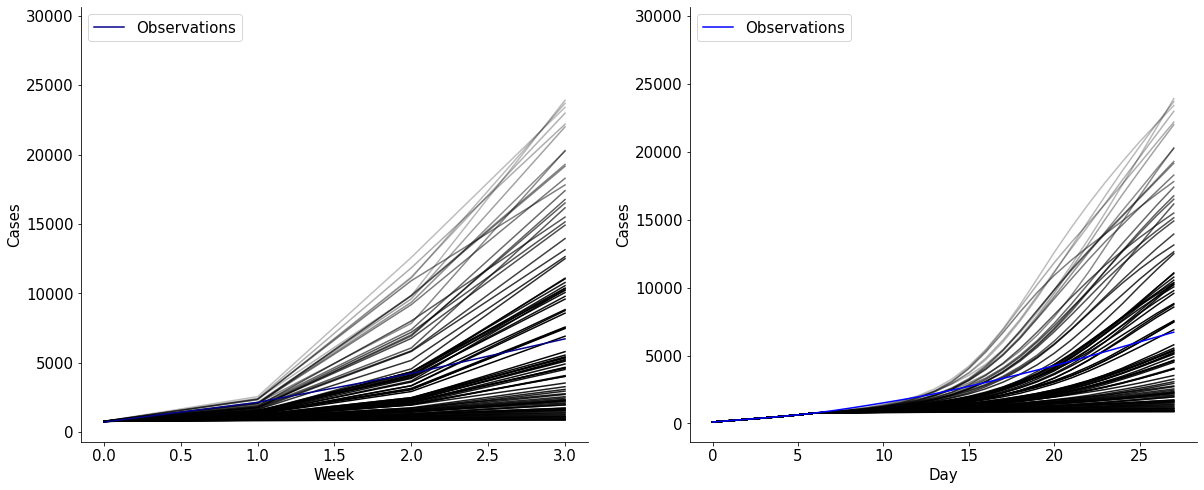

In [82]:
# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))

############## PLOT WEEKLY DATA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax1.plot(x, sim_l[i],
            color="black", alpha=1 - fitness_norm[i])  # (1-x because high fitness is bad)
# Plot observations
ax1.plot(x, obs_l[0], label="Observations", color="darkblue")
# Plot result from manually calibrated model
# ax1.plot(x, sim0, label="Initial sim", color="orange")
# Format
ax1.legend(fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Week", size=15)
ax1.set_ylabel("Cases",size=15)
# ax1.set_ylim(0,90000)

############## PLOT DAILY DATA 
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            color="black", alpha=1 - fitness_norm[i])  # (1-x because high fitness is bad)
# Plot observations
ax2.plot(x, cases_devon_daily['CumulativeCases'][0:ITERATIONS], label="Observations", color="blue")
# # Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Day", size=15)
ax2.set_ylabel("Cases",size=15)
# ax2.set_ylim(0,90000)
plt.show()

del _fitness, fitness_norm


2. Find the parameter modes
I can't work out how to find the modes (basically I think I need the largest value of the kde?) so instead just choose the parameter values from the best sample  
Find the 'optimal' parameters

In [83]:
####### Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
print(best_params)

{'retail': 0.30924901681949124, 'primary_school': 0.2488890605629217, 'secondary_school': 0.4760519605007004, 'work': 0.0793662193264949, 'presymptomatic': 0.5769378487102064, 'symptomatic': 0.14117035343714557, 'asymptomatic': 0.26932599795741596, 'current_risk_beta': 0.02275965521727913}


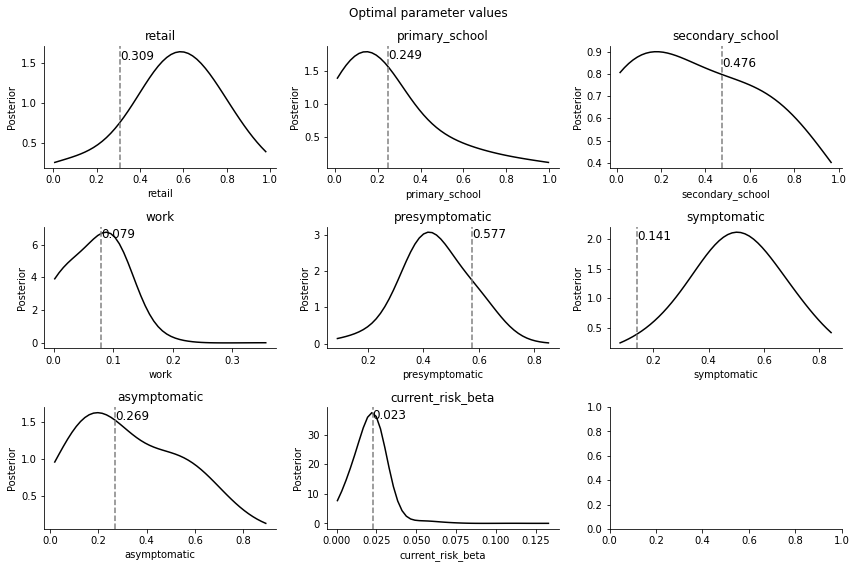

In [89]:
######## See how those parameters relate to the marginal posteriors
# fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,8))
fig, axes = plt.subplots(3,3, figsize=(12,8))

for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/abc_history.max_t, # Make earlier populations transparent
            color= "black" if t==abc_history.max_t else None # Make the last one black
        )
    #ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

In [90]:
# best params1
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness_bp, sim_bp, obs_bp, out_params_bp, summaries_bp) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True, quiet = False)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


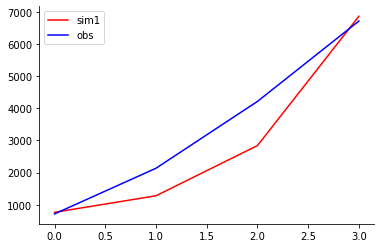

In [100]:
# Check the model returns the observations correctly (should be same as initial, default model)
np.array_equal(obs_manualcalibration, obs_bp)

fig, ax = plt.subplots(1,1)
x = range(len(sim_bp))
# ax.plot(x, sim_manualcalibration, label="sim0", color="orange")
ax.plot(x, sim_bp, label="sim1", color="red")
# Add fitness text
# for a, b in [(summaries_manualcalibration,fitness_manualcalibration), (summaries_bp, fitness_bp)]:
#     ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs_bp, label="obs", color="blue")
ax.legend()